In [48]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
import xgboost as xgb
from sklearn.metrics import roc_auc_score,f1_score,recall_score,accuracy_score,cohen_kappa_score,log_loss
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

In [49]:
df = pd.read_csv('train.csv')
df1=pd.read_csv('train.csv')

In [50]:
df.shape

(878049, 9)

In [53]:
df.head()


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,5/13/2015 23:53,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,5/13/2015 23:53,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,5/13/2015 23:33,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,5/13/2015 23:30,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,5/13/2015 23:30,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [54]:
df=df.drop(columns=["Descript","Resolution"])

In [56]:
Dates_datetime=list(map(lambda x:datetime.strptime(x,"%m/%d/%Y %H:%M"),df["Dates"]))

In [57]:
Dates_year=list(map(lambda x:x.year,Dates_datetime))
Dates_month=list(map(lambda x:x.month,Dates_datetime))
Dates_hour=list(map(lambda x:x.hour,Dates_datetime))

In [58]:
df["year"]=Dates_year
df["month"]=Dates_month
df["hour"]=Dates_hour
df.drop(columns="Dates",inplace=True)

In [59]:
df=df.merge(pd.get_dummies(df["DayOfWeek"]),on=df.index)
df.drop(columns="key_0",inplace=True)
df=df.merge(pd.get_dummies(df["PdDistrict"]),on=df.index)
df.drop(columns="key_0",inplace=True)

In [60]:
df.shape

(878049, 26)

In [62]:

# finding which crime is dominant in which district
mode_crime=[]
mode_crime_count=[]
dist=[]
for i,j in df.groupby(by="PdDistrict"):
    dist.append(i)
    crime_count=[]
    crime_name=[]
      for a,b in j.groupby(by="Category"):
        crime_count.append(len(b))
        crime_name.append(a)
    mode_crime.append(crime_name[np.argmax(np.array(crime_count))])
    mode_crime_count.append(max(crime_count))

In [63]:

crime_summary=pd.DataFrame({"District":dist,"dominant_crime":mode_crime,"count":mode_crime_count})

In [64]:
crime_summary

,District,dominant_crime,count
0,BAYVIEW,OTHER OFFENSES,17053
1,CENTRAL,LARCENY/THEFT,25060
2,INGLESIDE,OTHER OFFENSES,13203
3,MISSION,OTHER OFFENSES,19330
4,NORTHERN,LARCENY/THEFT,28630
5,PARK,LARCENY/THEFT,9146
6,RICHMOND,LARCENY/THEFT,9893
7,SOUTHERN,LARCENY/THEFT,41845
8,TARAVAL,LARCENY/THEFT,11845
9,TENDERLOIN,DRUG/NARCOTIC,17696


In [65]:
df.head()

,Category,DayOfWeek,PdDistrict,Address,X,Y,year,month,hour,Friday,...,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,WARRANTS,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,23,0,...,0,0,0,0,1,0,0,0,0,0
1,OTHER OFFENSES,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,23,0,...,0,0,0,0,1,0,0,0,0,0
2,OTHER OFFENSES,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,23,0,...,0,0,0,0,1,0,0,0,0,0
3,LARCENY/THEFT,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,23,0,...,0,0,0,0,1,0,0,0,0,0
4,LARCENY/THEFT,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,23,0,...,0,0,0,0,0,1,0,0,0,0


In [66]:
df.drop(columns=["DayOfWeek","PdDistrict"],inplace=True)

In [67]:
df.shape

(878049, 24)

In [68]:
encode_category=LabelEncoder().fit(np.sort(df["Category"]))
df["Category"]=encode_category.transform(df["Category"])

In [69]:
# PCA on co-ordinates
pca_encode=PCA().fit(df[["X","Y"]])
df[["X","Y"]]=pca_encode.transform(df[["X","Y"]])

In [70]:
df.drop(columns="Address",inplace=True)

In [71]:
dff=df.copy()

In [72]:
dff.head()

,Category,X,Y,year,month,hour,Friday,Monday,Saturday,Sunday,...,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,37,0.003454,0.003406,2015,5,23,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,21,0.003454,0.003406,2015,5,23,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,21,0.029309,0.002840,2015,5,23,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,16,0.029669,0.005488,2015,5,23,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,16,-0.000080,0.016129,2015,5,23,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [73]:
df.head()

,Category,X,Y,year,month,hour,Friday,Monday,Saturday,Sunday,...,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,37,0.003454,0.003406,2015,5,23,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,21,0.003454,0.003406,2015,5,23,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,21,0.029309,0.002840,2015,5,23,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,16,0.029669,0.005488,2015,5,23,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,16,-0.000080,0.016129,2015,5,23,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [74]:
x_train,x_test,y_train,y_test=train_test_split(df.drop(columns="Category"),df["Category"])

In [33]:
r1=xgb.XGBClassifier(n_estimators=1000,learning_rate=0.25,max_depth=4,gamma=0,colsample_bytree=1,colsample_bylevel=1,subsample=0.5,objective="multi:softmax")

In [34]:
r1.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],early_stopping_rounds=5,eval_metric="mlogloss")

[0]	validation_0-mlogloss:3.23651	validation_1-mlogloss:3.23627
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 5 rounds.
[1]	validation_0-mlogloss:3.0576	validation_1-mlogloss:3.05734
[2]	validation_0-mlogloss:2.93764	validation_1-mlogloss:2.93746
[3]	validation_0-mlogloss:2.84927	validation_1-mlogloss:2.84905
[4]	validation_0-mlogloss:2.78219	validation_1-mlogloss:2.78243
[5]	validation_0-mlogloss:2.72928	validation_1-mlogloss:2.72969
[6]	validation_0-mlogloss:2.68537	validation_1-mlogloss:2.68604
[7]	validation_0-mlogloss:2.65086	validation_1-mlogloss:2.65175
[8]	validation_0-mlogloss:2.62179	validation_1-mlogloss:2.62261
[9]	validation_0-mlogloss:2.59707	validation_1-mlogloss:2.59815
[10]	validation_0-mlogloss:2.57709	validation_1-mlogloss:2.57862
[11]	validation_0-mlogloss:2.55972	validation_1-mlogloss:2.56151
[12]	validation_0-mlogloss:2.54449	validation_1-mlogloss:2.54642


[124]	validation_0-mlogloss:2.35786	validation_1-mlogloss:2.40099
[125]	validation_0-mlogloss:2.35728	validation_1-mlogloss:2.40077
[126]	validation_0-mlogloss:2.35675	validation_1-mlogloss:2.40052
[127]	validation_0-mlogloss:2.35621	validation_1-mlogloss:2.40024
[128]	validation_0-mlogloss:2.35561	validation_1-mlogloss:2.39994
[129]	validation_0-mlogloss:2.35509	validation_1-mlogloss:2.39971
[130]	validation_0-mlogloss:2.35453	validation_1-mlogloss:2.39958
[131]	validation_0-mlogloss:2.354	validation_1-mlogloss:2.39937
[132]	validation_0-mlogloss:2.35356	validation_1-mlogloss:2.39927
[133]	validation_0-mlogloss:2.35306	validation_1-mlogloss:2.39905
[134]	validation_0-mlogloss:2.35239	validation_1-mlogloss:2.39867
[135]	validation_0-mlogloss:2.35189	validation_1-mlogloss:2.39854
[136]	validation_0-mlogloss:2.35137	validation_1-mlogloss:2.39838
[137]	validation_0-mlogloss:2.35095	validation_1-mlogloss:2.39817
[138]	validation_0-mlogloss:2.35038	validation_1-mlogloss:2.39791
[139]	valida

[249]	validation_0-mlogloss:2.30171	validation_1-mlogloss:2.38201
[250]	validation_0-mlogloss:2.3013	validation_1-mlogloss:2.38192
[251]	validation_0-mlogloss:2.30096	validation_1-mlogloss:2.38188
[252]	validation_0-mlogloss:2.30063	validation_1-mlogloss:2.38178
[253]	validation_0-mlogloss:2.30028	validation_1-mlogloss:2.38165
[254]	validation_0-mlogloss:2.29997	validation_1-mlogloss:2.3816
[255]	validation_0-mlogloss:2.29965	validation_1-mlogloss:2.38155
[256]	validation_0-mlogloss:2.29931	validation_1-mlogloss:2.38144
[257]	validation_0-mlogloss:2.29892	validation_1-mlogloss:2.38143
[258]	validation_0-mlogloss:2.2986	validation_1-mlogloss:2.38139
[259]	validation_0-mlogloss:2.29824	validation_1-mlogloss:2.38126
[260]	validation_0-mlogloss:2.29785	validation_1-mlogloss:2.38113
[261]	validation_0-mlogloss:2.29746	validation_1-mlogloss:2.38103
[262]	validation_0-mlogloss:2.29715	validation_1-mlogloss:2.38093
[263]	validation_0-mlogloss:2.29679	validation_1-mlogloss:2.38082
[264]	validat

[374]	validation_0-mlogloss:2.26102	validation_1-mlogloss:2.37293
[375]	validation_0-mlogloss:2.26071	validation_1-mlogloss:2.37289
[376]	validation_0-mlogloss:2.2604	validation_1-mlogloss:2.37276
[377]	validation_0-mlogloss:2.26013	validation_1-mlogloss:2.3727
[378]	validation_0-mlogloss:2.25983	validation_1-mlogloss:2.3726
[379]	validation_0-mlogloss:2.25956	validation_1-mlogloss:2.37255
[380]	validation_0-mlogloss:2.25929	validation_1-mlogloss:2.37252
[381]	validation_0-mlogloss:2.259	validation_1-mlogloss:2.37248
[382]	validation_0-mlogloss:2.25871	validation_1-mlogloss:2.3724
[383]	validation_0-mlogloss:2.25839	validation_1-mlogloss:2.37231
[384]	validation_0-mlogloss:2.25813	validation_1-mlogloss:2.37226
[385]	validation_0-mlogloss:2.25782	validation_1-mlogloss:2.37216
[386]	validation_0-mlogloss:2.25755	validation_1-mlogloss:2.37212
[387]	validation_0-mlogloss:2.25719	validation_1-mlogloss:2.37202
[388]	validation_0-mlogloss:2.25689	validation_1-mlogloss:2.372
[389]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.25, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [35]:
pred=r1.predict_proba(x_val)

In [36]:
log_loss(y_val,pred,labels=[i for i in range(0,39)])

2.3651582182322457

In [40]:
training, validation = train_test_split(df, train_size=.60)
model = RandomForestClassifier(n_estimators=200, max_depth=20, n_jobs=-1)
model.fit(training.ix[:,:-1], training.Category)
predicted = np.array(model.predict_proba(validation.ix[:,:-1]))
log_loss(validation.Category, predicted)

C:\Users\saipo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\saipo\Anaconda3\lib\site-packages\pandas\core\indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
C:\Users\saipo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable

0.500622977001282

In [43]:
# Random Forest Classifier
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

clf_A = RandomForestClassifier(max_depth=10, n_estimators=100)
clf_A.fit(x_train, y_train)
clf_probs = clf_A.predict_proba(x_test)
score = log_loss(y_test, clf_probs)
score

2.4940920604474237

In [44]:
# Random Forest Classifier
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

clf_A = RandomForestClassifier(max_depth=13, n_estimators=200)
clf_A.fit(x_train, y_train)
clf_probs = clf_A.predict_proba(x_test)
score = log_loss(y_test, clf_probs)
score

2.441825335286413

In [30]:
# Naive-Bayes
from sklearn.naive_bayes import BernoulliNB
clf_D = BernoulliNB()
clf_D.fit(x_train,y_train)
clf_probs_nb = clf_D.predict_proba(x_test)
score = log_loss(y_test, clf_probs_nb)
score

2.6358792561362208

In [45]:
# Random Forest Classifier
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

clf_A = RandomForestClassifier(max_depth=20, n_estimators=200)
clf_A.fit(x_train, y_train)
clf_probs = clf_A.predict_proba(x_test)
score = log_loss(y_test, clf_probs)
score

2.3738845809290114

In [47]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

clf_B = LogisticRegression(C=.001)
clf_B.fit(x_train,y_train)
clf_probs_logit = clf_B.predict_proba(x_test)
score = log_loss(y_test, clf_probs_logit)
score

C:\Users\saipo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\saipo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


2.617809246402067

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

In [58]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=100)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [72]:
knn_prob = classifier.predict_proba(X_test)
score = log_loss(y_test, knn_prob)
score

3.8873447107736427

In [33]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1000)
classifier.fit(X_train, y_train)
knn_prob = classifier.predict_proba(X_test)
score = log_loss(y_test, knn_prob)
score

2.673455776603427

In [34]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=34)
classifier.fit(X_train, y_train)
knn_prob = classifier.predict_proba(X_test)
score = log_loss(y_test, knn_prob)
score

6.5956889369927945

In [35]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3000)
classifier.fit(X_train, y_train)
knn_prob = classifier.predict_proba(X_test)
score = log_loss(y_test, knn_prob)
score

2.61339691424102

In [ ]:
from sklearn import preprocessing, cross_validation, svm
crime_svm = svm.SVC(kernel='linear')
crime_svm.fit(crime_train_data, crime_train_labels)
predicted = np.array(crime_svm.predict_proba(crime_test_data))
log_loss(crime_test_labels, predicted) 
crime_svm.score(crime_test_data, crime_test_labels)

In [30]:
x_test.shape


(219513, 22)

In [31]:
y_test.shape

(219513,)

In [32]:
x_train.shape

(658536, 22)

In [33]:
y_train.shape

(658536,)

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [37]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn import metrics

Using TensorFlow backend.


In [38]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
import collections
def to_xy(dff, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)

In [39]:


x,y = to_xy(dff,"Category")

C:\Users\saipo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  # Remove the CWD from sys.path while we load stuff.


In [40]:
x1,x2,y1,y2=train_test_split(x,y)

In [41]:
x1

array([[-4.5552783e-02, -3.7227474e-02,  2.0110000e+03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.9388948e-02, -1.7078135e-02,  2.0070000e+03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.8674098e-02, -5.6551918e-03,  2.0100000e+03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 4.9210079e-03,  3.5838340e-04,  2.0140000e+03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 4.4366601e-03,  2.0696957e-02,  2.0070000e+03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 8.6212149e-03, -1.1364031e-02,  2.0100000e+03, ...,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [42]:
y1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [43]:
x2

array([[ 8.9017110e-04, -8.3651049e-03,  2.0070000e+03, ...,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.2336379e-02,  5.2122999e-02,  2.0130000e+03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.1726256e-03, -1.1735476e-02,  2.0050000e+03, ...,
         1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 3.3571742e-02, -6.2753782e-03,  2.0110000e+03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.4013931e-02,  3.2704607e-02,  2.0140000e+03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-3.0982494e-02, -3.1731565e-02,  2.0070000e+03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [44]:
y2

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [45]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath=r"C:\Users\saipo\Desktop\CSC215\finalproject\wts5.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(512, input_dim=x1.shape[1], activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(y1.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x1,y1,validation_data=(x2,y2),callbacks=[monitor,checkpointer],verbose=2,epochs=10)


print('Training finished...Loading the best model')  
print()


0
Train on 658536 samples, validate on 219513 samples
Epoch 1/10
 - 121s - loss: 3.0715 - val_loss: 2.6730
Epoch 2/10
 - 113s - loss: 2.6753 - val_loss: 2.6625
Epoch 3/10
 - 113s - loss: 2.6679 - val_loss: 2.6733
Epoch 4/10
 - 112s - loss: 2.6633 - val_loss: 2.6652
Epoch 5/10
 - 112s - loss: 2.6555 - val_loss: 2.6428
Epoch 6/10
 - 112s - loss: 2.6439 - val_loss: 2.6378
Epoch 7/10
 - 112s - loss: 2.6420 - val_loss: 2.6404
Epoch 8/10
 - 112s - loss: 2.6411 - val_loss: 2.6374
Epoch 9/10
 - 113s - loss: 2.6406 - val_loss: 2.6371
Epoch 10/10
 - 112s - loss: 2.6401 - val_loss: 2.6341
1
Train on 658536 samples, validate on 219513 samples
Epoch 1/10
 - 114s - loss: 3.1816 - val_loss: 2.6767
Epoch 2/10
 - 113s - loss: 2.6753 - val_loss: 2.6625
Epoch 3/10
 - 112s - loss: 2.6659 - val_loss: 2.6707
Epoch 4/10
 - 113s - loss: 2.6600 - val_loss: 2.6604
Epoch 5/10
 - 114s - loss: 2.6526 - val_loss: 2.6535
Epoch 6/10
 - 116s - loss: 2.6460 - val_loss: 2.6406
Epoch 7/10
 - 114s - loss: 2.6426 - val_los

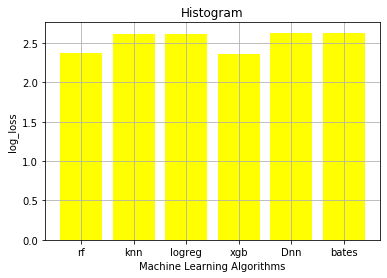

In [80]:
#seed is a function of numpy, which will give the same output each time it is executed.
np.random.seed(100)
names = ('rf','knn','logreg','xgb','Dnn','bates')
y_pos = np.arange(len(names))

bins = np.arange(len(names))
data= [2.37,2.61,2.61,2.36,2.63,2.63]


plt.bar(bins, data, align='center', facecolor='yellow')
plt.ylabel('log_loss')
plt.xlabel('Machine Learning Algorithms')
plt.title(r'Histogram')

plt.grid(True)

plt.xticks(y_pos, names)

plt.show()